# Imports

In [313]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from typing import Union
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf


plt.style.use('bmh')

nfl_colors = {
    "ARI": "#97233F",  # Arizona Cardinals
    "ATL": "#A71930",  # Atlanta Falcons
    "BAL": "#241773",  # Baltimore Ravens
    "BUF": "#00338D",  # Buffalo Bills
    "CAR": "#0085CA",  # Carolina Panthers
    "CHI": "#0B162A",  # Chicago Bears
    "CIN": "#FB4F14",  # Cincinnati Bengals
    "CLE": "#311D00",  # Cleveland Browns
    "DAL": "#041E42",  # Dallas Cowboys
    "DEN": "#FB4F14",  # Denver Broncos
    "DET": "#0076B6",  # Detroit Lions
    "GB":  "#203731",  # Green Bay Packers
    "HOU": "#03202F",  # Houston Texans
    "IND": "#002C5F",  # Indianapolis Colts
    "JAX": "#006778",  # Jacksonville Jaguars
    "KC":  "#E31837",  # Kansas City Chiefs
    "LAC": "#0080C6",  # Los Angeles Chargers
    "LAR": "#003594",  # Los Angeles Rams
    "LV":  "#000000",  # Las Vegas Raiders
    "MIA": "#008E97",  # Miami Dolphins
    "MIN": "#4F2683",  # Minnesota Vikings
    "NE":  "#002244",  # New England Patriots
    "NO":  "#D3BC8D",  # New Orleans Saints
    "NYG": "#0B2265",  # New York Giants
    "NYJ": "#125740",  # New York Jets
    "PHI": "#004C54",  # Philadelphia Eagles
    "PIT": "#FFB612",  # Pittsburgh Steelers
    "SEA": "#002244",  # Seattle Seahawks
    "SF":  "#AA0000",  # San Francisco 49ers
    "TB":  "#D50A0A",  # Tampa Bay Buccaneers
    "TEN": "#0C2340",  # Tennessee Titans
    "WAS": "#773141",
    "LA": "blue"# Washington Football Team
}

# Processing functions

In [314]:
def calculate_angle(point1, point2):
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    
    # Calculate angle in radians using atan2
    angle_radians = np.arctan2(dy, dx)
    
    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)
    
    
    
    return (angle_degrees -90) *-1


def _distance_from_point(x_distance: Union[float, np.ndarray], 
                        x_point: Union[float, np.ndarray], 
                        y_distance: Union[float, np.ndarray], 
                        y_point: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Calculate the Euclidean distance from a specific point or points to one or more other points.

    Parameters:
    x_distance (Union[float, np.ndarray]): X-coordinate(s) of the point(s) to calculate the distance to.
    x_point (Union[float, np.ndarray]): X-coordinate(s) of the reference point(s).
    y_distance (Union[float, np.ndarray]): Y-coordinate(s) of the point(s) to calculate the distance to.
    y_point (Union[float, np.ndarray]): Y-coordinate(s) of the reference point(s).

    Returns:
    Union[float, np.ndarray]: The Euclidean distance(s) between the pairs of points.
                               Returns a single float if the inputs are floats, or an array of floats if the inputs are arrays.
    """
    return np.sqrt((x_distance - x_point)**2 + (y_distance - y_point)**2)

def convert_height_to_inches(arr: pd.Series)->pd.Series:
    if arr.dtype == 'object':
        height_inches = arr.str[0].astype('int')*12 +arr.str[2].astype('int')
        return height_inches
    return arr

def flatten_and_rename(df,index_cols, value_cols):
    df.columns = index_cols + value_cols 
    return df
def calculate_yac(df:pd.DataFrame)->pd.Series:
    direction_right_bool = df['playDirection'] =='right'
    df['yac'] = df['end_play_event'] - df['pass_outcome_caught']
    df['yac'] = np.where(direction_right_bool,df['yac'],(-1*df['yac']))
    return df

def calculate_distance_down_field(df:pd.DataFrame)->pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_down_field'] = df['x'] - df['ball_carrier_x']
        df.loc[~direction_right_bool,'yards_down_field'] = -1* df['yards_down_field']
        return df
        
def calculate_distance_right(df:pd.DataFrame)-> pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_right'] = df['y'] - df['ball_carrier_y']
        df.loc[~direction_right_bool,'yards_right'] = -1* df['yards_right']
        return df
    

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
def _angle_of_approach(theta_1, theta_2):
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to be within -180 to 180 degrees
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # The angle of approach should be the absolute value as it represents the magnitude
    # of the smallest angle needed to face the ball carrier
    angle_of_approach = abs(angle_of_approach)
    
    return angle_of_approach

def _angle_from_point(x_angle, x_point, y_angle, y_point):
    """
    Calculate the angle from a reference point (x_point, y_point) to a target point (x_angle, y_angle).
    The angle is calculated with 0 degrees being along the positive y-axis, and positive angles
    being clockwise from there.
    
    Parameters:
    x_angle (np.ndarray or pd.Series): x-coordinates of the target points
    x_point (np.ndarray or pd.Series): x-coordinates of the reference points
    y_angle (np.ndarray or pd.Series): y-coordinates of the target points
    y_point (np.ndarray or pd.Series): y-coordinates of the reference points
    
    Returns:
    np.ndarray or pd.Series: The angles from the reference points to the target points in degrees
    """

    x_diff = x_angle - x_point
    y_diff = y_angle - y_point
    angle_radians = np.arctan2( y_diff , x_diff)
    angle_degrees = (np.degrees(angle_radians) -90) * -1
    
    negative_angle_mask = angle_degrees < 0
    angle_degrees[negative_angle_mask] =  angle_degrees[negative_angle_mask] +360
    return angle_degrees

def _angle_of_approach(theta_1, theta_2) -> pd.DataFrame:
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to the range [-180, 180)
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # Since we want a positive angle representing the magnitude of the approach angle,
    # take the absolute value
    return np.abs(angle_of_approach)



def create_ball_carrier_position_cols(tracking_df, plays_df):
    """
    For all frames returns x, y,s,a,dis for ball carrier on play
    Preprocessing Step for calculate ball carrier diffs
    Creates 1 record per ball carrier
    """
    keep_cols = ['gameId','playId','ballCarrierDisplayName','frameId',
             'x', 'y', 's','a','dis','defensiveTeam','dir']
    rename_cols = ['x', 'y', 's','a','dis','o','a','dir']
    rename_prefix = 'ball_carrier_'
    final_join_cols = ['gameId','playId','frameId']
    return(tracking_df
           .merge(
                 plays_df, 
                 left_on= ['gameId','playId','nflId'], 
                 right_on = ['gameId','playId','ballCarrierId'], 
                 how = 'inner'
              )
           .loc[:, keep_cols]
           .rename({col :rename_prefix + col for col in rename_cols} , axis = 1)
          )

def calculate_ball_carrier_diffs(ball_carrier_pos_df: pd.DataFrame)-> pd.DataFrame:
    return (ball_carrier_pos_df
           .assign(distance_from_ball_carrier = lambda df: _distance_from_point(df['x'],df['ball_carrier_x'],df['y'],df['ball_carrier_y']),
                   
                   angle_from_ball_carrier = lambda df: _angle_from_point(df['ball_carrier_x'],df['x'],df['ball_carrier_y'],df['y']), 
                   angle_of_approach = lambda df: _angle_of_approach(df['angle_from_ball_carrier'] , df['dir']),
                   cos_angle_of_approach = lambda df: cos_in_degrees(df['angle_of_approach']),
                   ball_carrier_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['ball_carrier_y']),
                   player_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['y'])
                  )
            
           .pipe(lambda df: calculate_distance_down_field(df))
           .pipe(lambda df: calculate_distance_right(df))
        )
    
def create_event_frame_intermediate_join(tracking_df, event = "pass_outcome_caught"):
    return tracking_df.loc[tracking_df['event']==event,['gameId','playId','frameId']].drop_duplicates().reset_index(drop = True)

def players_within_x(df, cutoff_distance = 3):
    return np.sum((df['distance_from_ball_carrier'] <= cutoff_distance))

def calculate_players_within_radius(distance_from_ball_carrier, cutoff_distance):
    return np.sum((distance_from_ball_carrier <= cutoff_distance))
    
def calculate_players_downfield_within_radius(df, cutoff_downfield, cutoff_radius):
    downfield_mask = df['yards_down_field'] <= cutoff_downfield
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
    
def calculate_players_upfield_within_radius(df, cutoff_upfield, cutoff_radius):
    downfield_mask = df['yards_down_field'].between(cutoff_upfield,-0.0001)
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
     

def towards_sideline_vector(value,angle):
    angle_radians = np.radians((angle))
    return np.abs(value*np.cos(angle_radians))

def towards_endzone_vector(value,angle):
    angle_radians = np.radians(angle)
    return np.abs(value*np.sin(angle_radians))

def map_angle_to_category(angle):
    if 315 <= angle or angle <= 45:
        return 'sideline'
    elif 45 < angle <= 135:
        return 'endzone'
    elif 135 < angle <= 225 :
        return 'sideline'
    # You can add more conditions for other ranges
    else:
        return 'endzone'  # Default category for angles that don't fit the above criteria

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
    
def cos_in_degrees(angle_degrees):
    return np.cos(np.radians(angle_degrees))

def create_behind_los_flag(yac_df:pd.DataFrame):
    direction_right_mask = yac_df['playDirection'] == 'right'
    abs_greater_than_catch_mask = yac_df['absoluteYardlineNumber'] > yac_df['pass_outcome_caught']
    
    left_los_mask = direction_right_mask & abs_greater_than_catch_mask
    right_los_mask = ~direction_right_mask & ~abs_greater_than_catch_mask
    
    yac_df['behind_los_flag'] = 0
    yac_df.loc[left_los_mask,'behind_los_flag'] = 1
    yac_df.loc[right_los_mask,'behind_los_flag'] = 1
    
    return yac_df[['gameId','playId','behind_los_flag']]



def plot_actual_vs_predicted(y_pred, y_test, title =''):
    if not title:
        title = 'Actual vs. Predicted  Values with R-squared'
    r_squared= r2_score( y_test, y_pred)
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=y_test)

    # Add the y=x line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

    # Annotate the plot with the R-squared value
    plt.text(x=min(y_pred), y=max(y_test), s=f'R-squared = {r_squared:.2f}')

    # Label the axes and show the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
    
def subtract_series_set_negative_to_zero(series1, series2):
    # Subtract series2 from series1
    result = series1 - series2
    # Set negative results to zero
    result[result < 0] = 0
    return result

def calculate_snap_to_catch_diff(tracking_df):
    df_snap = tracking_df[tracking_df['event'] == 'ball_snap'][['gameId','playId','time']]
    df_catch = tracking_df[tracking_df['event'] == 'pass_outcome_caught'][['gameId','playId','time']]
                                                                      
    # Merge the DataFrames on gameId and playId
    merged_df = pd.merge(df_snap, df_catch, on=['gameId', 'playId'], suffixes=('_snap', '_catch'))
    
    # Convert the time columns to datetime
    merged_df['time_snap'] = pd.to_datetime(merged_df['time_snap'], format='%Y-%m-%d %H:%M:%S')
    merged_df['time_catch'] = pd.to_datetime(merged_df['time_catch'], format='%Y-%m-%d %H:%M:%S')
    
    # Calculate the time difference in seconds
    merged_df['snap_to_catch_time'] = (merged_df['time_catch'] - merged_df['time_snap']).dt.total_seconds()
    
    # Return the DataFrame with the difference
    return merged_df[['gameId', 'playId', 'snap_to_catch_time']].drop_duplicates().reset_index(drop=True)  


def rank_distance_from_ball_carrier(df: pd.DataFrame)->pd.Series:
    return (df
            .groupby(['gameId','playId','offense_or_defense'],as_index = False)['distance_from_ball_carrier']
            .rank(method = 'min')
           )
    

# Read In Data

In [315]:
tackle_df = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')
plays_df = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')
players_df = pd.read_csv('nfl-big-data-bowl-2024/players.csv')
tracking_df = pd.concat(
    
                     [
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_8.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_7.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_6.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_5.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_4.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_3.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_2.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_1.csv')
                    ]
)

# Prepare Players Data

In [316]:
players_df['height'] = convert_height_to_inches(players_df['height'])

# Prepare Plays Data

In [275]:
plays_df = (plays_df
            .query('passResult =="C"') # Filter to plays with a catch
            .assign(
                minute_of_quarter=lambda df: df['gameClock'].str.split(':', expand=True)[0].astype(int),
                abs_score_diff=lambda df: np.abs(df['preSnapHomeScore'] - df['preSnapVisitorScore'])
            )
            .merge(tracking_df[['playId','gameId','playDirection']].drop_duplicates(), on = ['playId','gameId'], how = 'inner')
           )


end_of_half_mask = ~((plays_df['quarter'].isin([2,4])) & (plays_df['minute_of_quarter'] <= 2)) # When Against the clock teams don't go for extra yards
end_4th_blowout_mask =  ~((plays_df['quarter'] == 4) & (plays_df['minute_of_quarter'] <= 5) & (plays_df['abs_score_diff'] < 10)) # Eliminate Times of Game when Shell Defense
redzone_mask_left = (plays_df['playDirection'] == 'left') & (plays_df['absoluteYardlineNumber'] >= 35) 
redzone_mask_right = (plays_df['playDirection'] == 'right') & (plays_df['absoluteYardlineNumber'] <= 85)

redzone_mask = redzone_mask_left | redzone_mask_right

total_mask = end_of_half_mask & end_4th_blowout_mask & redzone_mask


# Remove Plays with Missed Tackles
no_missed_tackle_id_df = tackle_df.query('pff_missedTackle == 1')[['gameId','playId']].drop_duplicates().reset_index(drop=True)





plays_df = (plays_df.loc[total_mask,]
          .merge(no_missed_tackle_id_df, on = ['gameId','playId'], how = 'left', indicator = True )
          .query('_merge == "left_only"')
          .drop('minute_of_quarter', axis = 1)
          .assign(yards_from_td = lambda df: np.where(df['playDirection'] =='right', 110 - df['absoluteYardlineNumber'],df['absoluteYardlineNumber']-10))
          .merge(players_df[['nflId','height','weight']] ,left_on = 'ballCarrierId', right_on = 'nflId', how = 'inner')
          .rename({'height':'ball_carrier_height', 'weight':'ball_carrier_weight'},axis = 1)
          .drop('nflId',axis =1)
           )
np.sum(redzone_mask)

4531

# Create Ball Carrier Diffs

In [276]:
tracking_cols = ['gameId','playId','nflId','frameId','x','y','s','a','dis','playDirection','displayName','club','dir','o']
player_cols = ['height','weight','position','nflId']
ball_carrier_diffs =    (create_ball_carrier_position_cols(tracking_df, plays_df) # Creates One record per ball carrier on play with position cols
                        .merge(tracking_df[tracking_cols], on = ['gameId','playId','frameId'] , how = 'inner') # Joins all tracking data to setup distance calcs
                        .pipe(lambda df: calculate_ball_carrier_diffs(df)) # Calculates distances from ball carrier
                        .merge(players_df[player_cols], on = 'nflId', how = 'inner') # Adds additional player info on the nflId
                        .assign(offense_or_defense = lambda df: np.where(df['club'] == df['defensiveTeam'],'D','O') ) # Assigns player to offense or defense on the play
)



# Create YAC DF

In [277]:

track_df_keep_cols = ['gameId','playId','nflId','displayName','frameId','event','x','y','club']
play_df_keep_cols = ['down',
                     'yardsToGo',
                     'abs_score_diff',
                     'playDescription',
                     'playDirection',
                     'quarter',
                     'gameClock',
                     'passLength',
                     'yardlineNumber',
                     'absoluteYardlineNumber',
                     'defendersInTheBox']
index_cols = ['gameId',
              'playId',
              'nflId',
              'displayName',
              'playDirection',
              'yardlineNumber',
              'down',
              'yardsToGo',
              'playDescription',
              'quarter',
              'abs_score_diff',
              'gameClock',
              'passLength',
              'absoluteYardlineNumber',
              'defendersInTheBox'
             ]



end_play_event_map = {
    "pass_outcome_caught":"pass_outcome_caught",
    "tackle":"end_play_event",
    "out_of_bounds":"end_play_event",
    "fumble":"end_play_event",
#     "touchdown" :"end_play_event" 
}

end_of_event_cols = ['fumble','out_of_bounds','pass_outcome_caught','tackle'] 
calc_cols = ['pass_outcome_caught','end_of_event']


yac_df = (tracking_df.loc[tracking_df['displayName'] == 'football', track_df_keep_cols]
    .merge(plays_df, left_on= ['gameId','playId'] , right_on = ['gameId','playId'], how = 'inner')
    .query('event == "pass_outcome_caught" | event == "tackle" | event =="out_of_bounds" | event == "fumble"')
    .assign(end_play_event = lambda df: df['event'].map(end_play_event_map))
    .sort_values(['gameId','playId','frameId'])
    .pivot(index = index_cols,columns =['event'], values=['x'] )
    .reset_index()
    .pipe(lambda df: flatten_and_rename(df,index_cols,end_of_event_cols))
    .query("pass_outcome_caught > 10 & pass_outcome_caught < 110") # Filter for Touchdowns in the end zone
    .assign(end_play_event = lambda df: df['tackle'].combine_first(df['out_of_bounds'].combine_first(df['fumble'])))
    .pipe(lambda df: calculate_yac(df))
    # .assign(yac = lambda df: np.where(df['yac'] <0 ,0,df['yac']))
    .query("yac > -3")
    # .query("yac < 20")
    .assign(yac = lambda df:  df['yac'] + 3.1)
)
          
          

# Create Behind LOS Flag DF

<Axes: xlabel='yac', ylabel='Count'>

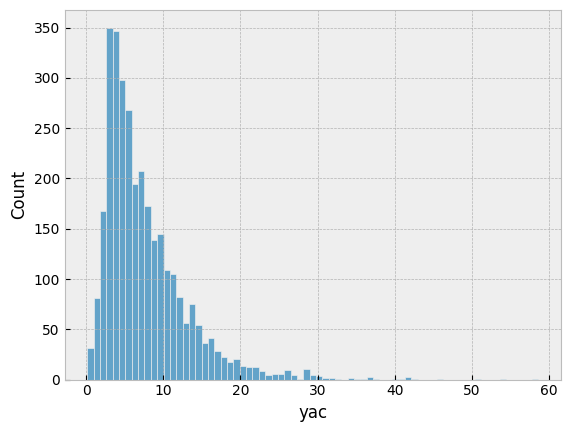

In [278]:
sns.histplot(yac_df['yac'])

In [279]:
behind_los_flag_df = create_behind_los_flag(yac_df)  

# Create Feature Setup DF

In [282]:
yac_df_cols = ['gameId',
               'playId',
               'yac',
               'down',
               'yardsToGo',
               'quarter',
               'gameClock',
               'passLength',
               'yardlineNumber',
               'absoluteYardlineNumber',
               'defendersInTheBox',
               'abs_score_diff',
              ]
feature_setup_df = (yac_df[yac_df_cols]
.merge(create_event_frame_intermediate_join(tracking_df) , on = ['gameId','playId'])
.merge(ball_carrier_diffs, on = ['gameId','playId','frameId'], how = 'inner')
.query("ballCarrierDisplayName != displayName" )
.assign(ball_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        ball_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        player_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['s'],df['dir']),
        player_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['s'],df['dir']),
        ranked_closest_player = lambda df: rank_distance_from_ball_carrier(df),
        speed_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] * df['s'],
        distance_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] *df['distance_from_ball_carrier'] ,
        # height_diff = lambda df: df['ball_carrier_height'] - df['height'],
        # weight_diff = lambda df: df['ball_carrier_weight'] - df['weight']
       )
)



# Feature Setup Display
feature_setup_df_display = (yac_df[yac_df_cols]
.merge(create_event_frame_intermediate_join(tracking_df) , on = ['gameId','playId'])
.merge(ball_carrier_diffs, on = ['gameId','playId','frameId'], how = 'inner')
.assign(ball_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        ball_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        player_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['s'],df['dir']),
        player_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['s'],df['dir']),
        ranked_closest_player = lambda df: rank_distance_from_ball_carrier(df),
        speed_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] * df['s'],
        distance_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] *df['distance_from_ball_carrier'] ,
        # height_diff = lambda df: df['ball_carrier_height'] - df['height'],
        # weight_diff = lambda df: df['ball_carrier_weight'] - df['weight']
       )
)


# Create Ball Carrier Metrics DF

In [283]:
ball_carrier_cols = ['gameId','playId'] + list(feature_setup_df.filter(like = 'ball_carrier_', axis = 1).columns)

ball_carrier_metrics_df = feature_setup_df[ball_carrier_cols].drop_duplicates().reset_index(drop=True)

# Create Closest Players O and D DF

In [129]:
# # Build Closest Defender df
# d_mask = feature_setup_df['offense_or_defense'] == 'D'
# closest_defender_df = (feature_setup_df[d_mask]
# .groupby(['gameId','playId'],as_index = False)
# .agg({'distance_from_ball_carrier':min})
# .merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
# )


# # Build closest Offensive df

# o_mask = feature_setup_df['offense_or_defense'] == 'O'
# closest_offensive_df = (feature_setup_df[o_mask]
# .groupby(['gameId','playId'],as_index = False)
# .agg({'distance_from_ball_carrier':min})
# .merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
# )

# closest_defender_df.columns = [f"{col}_closest_defender" for col in closest_defender_df.columns] 
# closest_offensive_df.columns = [f"{col}_closest_offense" for col in closest_offensive_df.columns]

# # closest_offensive_df.columns

In [284]:
feature_setup_df.columns

Index(['gameId', 'playId', 'yac', 'down', 'yardsToGo', 'quarter', 'gameClock',
       'passLength', 'yardlineNumber', 'absoluteYardlineNumber',
       'defendersInTheBox', 'abs_score_diff', 'frameId',
       'ballCarrierDisplayName', 'ball_carrier_x', 'ball_carrier_y',
       'ball_carrier_s', 'ball_carrier_a', 'ball_carrier_dis', 'defensiveTeam',
       'ball_carrier_dir', 'nflId', 'x', 'y', 's', 'a', 'dis', 'playDirection',
       'displayName', 'club', 'dir', 'o', 'distance_from_ball_carrier',
       'angle_from_ball_carrier', 'angle_of_approach', 'cos_angle_of_approach',
       'ball_carrier_distance_from_sideline', 'player_distance_from_sideline',
       'yards_down_field', 'yards_right', 'height', 'weight', 'position',
       'offense_or_defense', 'ball_carrier_speed_toward_sideline',
       'ball_carrier_speed_toward_endzone',
       'player_carrier_speed_toward_endzone',
       'player_carrier_speed_toward_sideline', 'ranked_closest_player',
       'speed_times_cos_angle_approa

# N Closest Players

In [285]:
# Create a new column combining rank with offense/defense
feature_setup_df['pivot_column'] = "closest_player" + "_" + feature_setup_df['ranked_closest_player'].astype(int).astype(str) + '_' + feature_setup_df['offense_or_defense']

# Use these on join for model setup
n_closest_index_cols = [
              'gameId', 
              'playId',
        ]


value_cols = ['yards_down_field', 
              'cos_angle_of_approach',
              'speed_times_cos_angle_approach',
              'distance_times_cos_angle_approach',
              'distance_from_ball_carrier',
              'yards_right'
             ]

n_closest_player_metrics = (feature_setup_df
    .query('ranked_closest_player < 7')
    .pivot_table(
                index=n_closest_index_cols,
                columns='pivot_column',
                values=value_cols
    ).reset_index()
)

n_closest_player_metrics.columns = list(n_closest_index_cols) +  ['_'.join(col).strip() for col in n_closest_player_metrics.iloc[:,len(n_closest_index_cols):]]

n_closest_player_metrics

,gameId,playId,cos_angle_of_approach_closest_player_1_D,cos_angle_of_approach_closest_player_1_O,cos_angle_of_approach_closest_player_2_D,cos_angle_of_approach_closest_player_2_O,cos_angle_of_approach_closest_player_3_D,cos_angle_of_approach_closest_player_3_O,cos_angle_of_approach_closest_player_4_D,cos_angle_of_approach_closest_player_4_O,...,yards_right_closest_player_2_D,yards_right_closest_player_2_O,yards_right_closest_player_3_D,yards_right_closest_player_3_O,yards_right_closest_player_4_D,yards_right_closest_player_4_O,yards_right_closest_player_5_D,yards_right_closest_player_5_O,yards_right_closest_player_6_D,yards_right_closest_player_6_O
0,2022090800,56,0.814612,-0.967214,0.722822,0.763387,0.958609,-0.730889,0.699949,-0.854480,...,2.23,6.28,6.85,4.25,5.95,5.60,-0.50,8.89,2.45,3.15
1,2022090800,122,0.974375,0.939816,0.773777,0.563661,0.690700,-0.216816,0.986698,0.997603,...,3.71,5.97,2.48,7.03,6.87,7.78,8.87,7.19,5.22,4.89
2,2022090800,167,0.810325,0.153423,0.899492,-0.999087,0.695559,-0.450665,-0.803074,0.892559,...,7.45,3.34,-1.31,0.79,3.64,12.13,0.26,3.73,10.64,3.10
3,2022090800,212,0.838452,0.299848,0.379905,-0.429267,-0.540330,0.816117,0.963445,0.989583,...,1.88,6.98,6.37,9.76,12.32,11.75,14.37,14.25,16.53,16.52
4,2022090800,364,0.796360,0.993687,0.979249,0.696104,0.988429,0.650854,0.902185,0.904531,...,4.33,22.23,8.67,15.34,15.64,24.91,20.25,22.03,18.00,27.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,2022103100,2789,0.951549,0.968501,0.461500,0.947602,-0.465653,0.496803,0.439011,0.863281,...,9.34,9.10,9.04,9.80,13.35,9.25,3.88,8.40,-10.51,12.55
3167,2022103100,3087,0.984392,-0.070183,0.826242,0.216256,0.931808,0.851021,-0.296134,0.387248,...,2.76,6.28,8.21,-8.92,6.41,-10.61,-8.75,-15.40,8.62,-14.07
3168,2022103100,3189,0.901102,0.985899,0.904495,0.999973,0.582919,0.997791,0.989515,0.999889,...,-7.34,-9.71,-7.73,-9.56,-9.33,-10.76,-8.14,-10.61,-9.42,-10.18
3169,2022103100,3275,0.993709,0.934799,0.918677,-0.931747,-0.947197,0.973616,0.948375,0.986361,...,9.95,-1.00,-0.39,21.09,15.50,23.56,4.94,24.51,23.48,26.33


# Visualize Play and Check Feature Setup Caculations

In [286]:
feature_setup_df[['playId','gameId','yac','playDirection']].sort_values('yac', ascending = False).drop_duplicates().iloc[40:60]

,playId,gameId,yac,playDirection
9086,286,2022091200,28.350000,left
47149,573,2022101603,28.350000,left
16354,1297,2022091811,28.190001,left
37492,1099,2022100901,27.650003,right
16388,1390,2022091811,27.270002,right
47813,664,2022101604,26.910005,right
50633,181,2022101609,26.770002,left
26249,989,2022092512,26.729997,right
32793,1107,2022100208,26.720003,right
25024,1497,2022092510,26.280000,right


In [287]:
play_id =2179
game_id = 2022092600
feature_setup_df[['ballCarrierDisplayName',
                  'displayName',
                  'club',
                  'ball_carrier_speed_toward_endzone',
                  'ball_carrier_speed_toward_sideline',
                  'ball_carrier_s',
                  'absoluteYardlineNumber',        
                  'distance_from_ball_carrier',
                  'playDirection',
                  'ball_carrier_x', 
                  'ball_carrier_y',
                  'x',
                  'y',
                  'angle_from_ball_carrier',
                  'angle_of_approach',
                  'cos_angle_of_approach',
                  'dir',
                  'yards_down_field',
                  'yards_right',
                  'playDirection',
                  'passLength',
                  
         'ball_carrier_speed_toward_sideline',
         'ball_carrier_speed_toward_endzone',
         'player_carrier_speed_toward_endzone',
         'player_carrier_speed_toward_sideline',
         'dis',
         's',
         'o',
         'offense_or_defense',
          'yac']].loc[(feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id),].sort_values(['offense_or_defense','distance_from_ball_carrier']).head(12)

,ballCarrierDisplayName,displayName,club,ball_carrier_speed_toward_endzone,ball_carrier_speed_toward_sideline,ball_carrier_s,absoluteYardlineNumber,distance_from_ball_carrier,playDirection,ball_carrier_x,...,passLength,ball_carrier_speed_toward_sideline,ball_carrier_speed_toward_endzone,player_carrier_speed_toward_endzone,player_carrier_speed_toward_sideline,dis,s,o,offense_or_defense,yac
27544,Saquon Barkley,Demarcus Lawrence,DAL,1.591317,4.80326,5.06,72,5.038770,right,68.8,...,-2.0,4.80326,1.591317,1.794833,2.366321,0.29,2.97,51.76,D,19.890001
27546,Saquon Barkley,Leighton Vander Esch,DAL,1.591317,4.80326,5.06,72,7.004070,right,68.8,...,-2.0,4.80326,1.591317,1.141430,5.696774,0.58,5.81,293.80,D,19.890001
27551,Saquon Barkley,Osa Odighizuwa,DAL,1.591317,4.80326,5.06,72,7.040810,right,68.8,...,-2.0,4.80326,1.591317,0.723731,1.302426,0.14,1.49,31.02,D,19.890001
27559,Saquon Barkley,Quinton Bohanna,DAL,1.591317,4.80326,5.06,72,8.069430,right,68.8,...,-2.0,4.80326,1.591317,0.083859,0.442117,0.05,0.45,24.92,D,19.890001
27550,Saquon Barkley,Micah Parsons,DAL,1.591317,4.80326,5.06,72,8.448207,right,68.8,...,-2.0,4.80326,1.591317,1.328933,2.700748,0.30,3.01,163.20,D,19.890001
27548,Saquon Barkley,Donovan Wilson,DAL,1.591317,4.80326,5.06,72,10.509205,right,68.8,...,-2.0,4.80326,1.591317,0.856983,5.250522,0.52,5.32,198.36,D,19.890001
27547,Saquon Barkley,Dorance Armstrong,DAL,1.591317,4.80326,5.06,72,10.679799,right,68.8,...,-2.0,4.80326,1.591317,2.293863,4.352539,0.51,4.92,171.05,D,19.890001
27558,Saquon Barkley,Malik Hooker,DAL,1.591317,4.80326,5.06,72,19.613773,right,68.8,...,-2.0,4.80326,1.591317,1.450905,1.347321,0.20,1.98,297.95,D,19.890001
27545,Saquon Barkley,Anthony Brown,DAL,1.591317,4.80326,5.06,72,19.691724,right,68.8,...,-2.0,4.80326,1.591317,4.326845,2.299656,0.50,4.90,2.34,D,19.890001
27549,Saquon Barkley,Trevon Diggs,DAL,1.591317,4.80326,5.06,72,31.070893,right,68.8,...,-2.0,4.80326,1.591317,1.705188,0.636187,0.18,1.82,210.03,D,19.890001


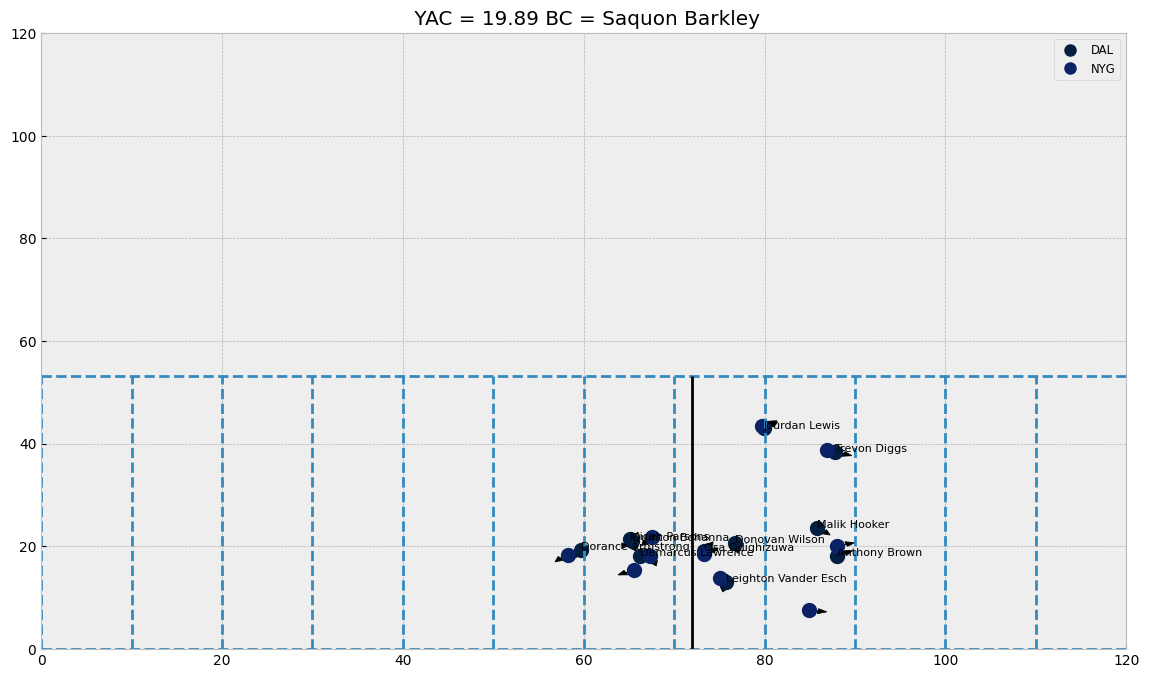

In [288]:
# Assuming nfl_colors is defined previously and feature_setup_df is your dataframe
colors = nfl_colors

# Set up the plot again with the requested adjustments
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size to your preference

play_mask = (feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id)

# Find the unique clubs involved in this specific play
unique_clubs = feature_setup_df.loc[play_mask, 'club'].unique()

# Initialize a dictionary to hold the legend handles to ensure unique labels
legend_handles = {}

# Plot player positions with colors based on 'club'
for _, row in feature_setup_df.loc[play_mask].iterrows():
    bc_name = row['ballCarrierDisplayName']
    o_d = row['offense_or_defense']
    club_color = colors[row['club']]
    if row['club'] not in legend_handles:
        # Only add to legend if not already present
        legend_handles[row['club']] = plt.Line2D([0], [0], marker='o', color=club_color, markersize=8, linestyle='')

    ax.plot(row['x'], row['y'], 'o', markersize=10, color=club_color, label=row['club'])  # Larger dots
    # Annotate player name at a quarter of the default font size
    if o_d =='D' or row['displayName'] == bc_name:
        ax.text(row['x'], row['y'], row['displayName'], fontsize=plt.rcParams['font.size'] * 0.8)

    # Calculate the arrow direction based on the 'dir' column
    radians = np.radians((row['dir'] -90) * -1)
    dx = np.cos(radians)  # Change in x
    dy = np.sin(radians)  # Change in y

    # Draw the arrow from the player position in the direction they're facing
    ax.arrow(row['x'], row['y'], dx, dy, head_width=1, head_length=1, fc='k', ec='k')
    
    yac_title = np.round(row['yac'],2)
    ball_carrier = row['ballCarrierDisplayName']
    line_of_scrimmage = row['absoluteYardlineNumber']

# Set the limits of the plot
ax.set_xlim([0, 120])
ax.set_ylim([0, 120])
ax.hlines(y = [0,53.3],xmin = 0, xmax =120, linestyle = '--')
ax.vlines(x = line_of_scrimmage,ymin = 0, ymax =53.3, color = 'black')
ax.vlines(x = range(0,120,10),ymin = 0, ymax =53.3, linestyle = '--')
# Set title to include the two teams
if len(unique_clubs) == 2:
    title_teams = f"{unique_clubs[0]} vs {unique_clubs[1]}"
else:
    title_teams = "Multiple Teams"
ax.set_title(f' YAC = {yac_title} BC = {ball_carrier}')

# Create and add the legend for the clubs
handles, labels = [], []
for club in unique_clubs:
    handles.append(legend_handles[club])
    labels.append(club)
ax.legend(handles, labels, loc='upper right', fontsize='small')

# Show the plot
plt.show()

# Apply and Aggregate for Closest Player Features

In [289]:
group_by_list = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
                 'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]


# apply_result_df = (feature_setup_df
#                 .groupby(group_by_list, as_index=False)
#                 .apply(lambda df: pd.Series({
#                     'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
#                     'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
#                     'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
#                     'players_downfield_within_7': calculate_players_downfield_within_radius(df, 7, 7),
#                     'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
#                     'players_downfield_within_15': calculate_players_downfield_within_radius(df, 15, 15),
#                     'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
#                     'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
#                     'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
#                     'players_upfield_within_7': calculate_players_upfield_within_radius(df, -7, 7),
#                     'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
#                     'players_upfield_within_15': calculate_players_upfield_within_radius(df, -15, 15),
#                 })))


apply_index_cols = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
#                  'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]

apply_results_df = (feature_setup_df
                .groupby(group_by_list, as_index=False)
                .apply(lambda df: pd.Series({
                    'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
                    'players_downfield_within_2': calculate_players_downfield_within_radius(df, 2, 2),
                    'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
                    'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
                    'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
                    'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
                    'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
                    'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
                    'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
                    'players_behind_ball_carrier': calculate_players_upfield_within_radius(df, -120, 120)
                })))




apply_value_cols = ['players_downfield_within_1'
                    ,'players_downfield_within_2'
                    ,'players_downfield_within_3'
                    ,'players_downfield_within_5'
                    ,'players_downfield_within_10'
                    , 'players_upfield_within_1'
                    ,'players_upfield_within_3'
                    ,'players_upfield_within_5'
                    ,'players_upfield_within_10'
                    ,'players_behind_ball_carrier'
                   ]

apply_rename_cols = ['players_downfield_within_1_D'
                     ,'players_downfield_within_1_O'
                     ,'players_downfield_within_2_D'
                     ,'players_downfield_within_2_O'
                     ,'players_downfield_within_3_D'
                     ,'players_downfield_within_3_O'
                     ,'players_downfield_within_5_D'
                     ,'players_downfield_within_5_O'
                     ,'players_downfield_within_10_D'
                     ,'players_downfield_within_10_O'
                     ,'players_upfield_within_1_D'
                     ,'players_upfield_within_1_O'
                     ,'players_upfield_within_3_D'
                     ,'players_upfield_within_3_O'
                     ,'players_upfield_within_5_D'
                     ,'players_upfield_within_5_O'
                     ,'players_upfield_within_10_D'
                     ,'players_upfield_within_10_O'
                     ,'players_behind_ball_carrier_D'
                     ,'players_behind_ball_carrier_O'
                   ]

players_up_down_field_df = (apply_results_df.pivot(index = apply_index_cols
                      ,columns = ['offense_or_defense']
                      ,values = apply_value_cols)
                      .reset_index()
                      .pipe(lambda df: flatten_and_rename(df,apply_index_cols,apply_rename_cols))
)






agg_result = (feature_setup_df
              .groupby(['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName','offense_or_defense'], as_index=False)
              .agg({'distance_from_ball_carrier': [('within_radius_1', lambda x: calculate_players_within_radius(x, cutoff_distance=1)),
                                                   ('within_radius_2', lambda x: calculate_players_within_radius(x, cutoff_distance=2)),
                                                   ('within_radius_3', lambda x: calculate_players_within_radius(x, cutoff_distance=3)),
                                                   ('within_radius_5', lambda x: calculate_players_within_radius(x, cutoff_distance=5)),
                                                  ('within_radius_10', lambda x: calculate_players_within_radius(x, cutoff_distance=10))]
                   })

             )
                    
    
agg_result.columns =  ['_'.join(col).rstrip('_') for col in agg_result.columns.to_flat_index()]







value_cols = ['distance_from_ball_carrier_within_radius_1',
              'distance_from_ball_carrier_within_radius_2',
              'distance_from_ball_carrier_within_radius_3',
              'distance_from_ball_carrier_within_radius_5',
              'distance_from_ball_carrier_within_radius_10'
             ]

rename_cols = ['distance_from_ball_carrier_within_radius_1_D',
              'distance_from_ball_carrier_within_radius_1_O',
              'distance_from_ball_carrier_within_radius_2_D',
              'distance_from_ball_carrier_within_radius_2_O',
              'distance_from_ball_carrier_within_radius_3_D',
              'distance_from_ball_carrier_within_radius_3_O',
              'distance_from_ball_carrier_within_radius_5_D',
              'distance_from_ball_carrier_within_radius_5_O',
              'distance_from_ball_carrier_within_radius_10_D',
              'distance_from_ball_carrier_within_radius_10_O',
             ]
index_cols = ['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName']
player_within_radius_df = (agg_result.pivot(index= index_cols
                ,columns = ['offense_or_defense']
                 ,values = value_cols)
                .reset_index()
                .pipe(lambda df: flatten_and_rename(df,index_cols,rename_cols))
)

# Build Model Df and Set Predictor Cols

In [305]:
model_df = (
       players_up_down_field_df
      .merge(player_within_radius_df, on = ['gameId','playId','yac','ballCarrierDisplayName','yardsToGo'], how = 'inner')
      .merge(ball_carrier_metrics_df,on = ['gameId','playId'],how = 'inner')
      .merge(n_closest_player_metrics , on = n_closest_index_cols, how = 'inner')
      .merge(behind_los_flag_df, on = ['gameId','playId'] , how = 'inner')
      .merge(plays_df[~plays_df['passProbability'].isna()][['gameId','playId','passProbability']] , on = ['gameId','playId'], how = 'inner')
      .merge(plays_df[['gameId','playId','yards_from_td']] , on = ['gameId','playId'], how = 'inner')
      .pipe(lambda df: df.merge(pd.get_dummies( df['down'].astype('category'),drop_first = False, prefix = 'down', dtype = int) , left_index=True, right_index=True))
      .pipe(lambda df: df.merge(pd.get_dummies( df['quarter'].astype('category'),drop_first = False, prefix = 'quarter', dtype = int) , left_index=True, right_index=True))
      .assign(
              # players_downfield_within_2_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_O'],df['players_downfield_within_1_O']),
              # players_downfield_within_3_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_O'],df['players_downfield_within_2_O']),
              # players_downfield_within_5_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_O'],df['players_downfield_within_3_O']),
              # players_downfield_within_10_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_O'],df['players_downfield_within_5_O']),
              # players_downfield_within_2_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_D'],df['players_downfield_within_1_D']),
              # players_downfield_within_3_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_D'],df['players_downfield_within_2_D']),
              # players_downfield_within_5_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_D'],df['players_downfield_within_3_D']),
              # players_downfield_within_10_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_D'],df['players_downfield_within_5_D']),
              # distance_from_ball_carrier_within_radius_2_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_D'],df['distance_from_ball_carrier_within_radius_1_D']),
              # distance_from_ball_carrier_within_radius_3_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_D'],df['distance_from_ball_carrier_within_radius_2_D']),
              # distance_from_ball_carrier_within_radius_5_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_D'],df['distance_from_ball_carrier_within_radius_3_D']),
              # distance_from_ball_carrier_within_radius_10_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_D'],df['distance_from_ball_carrier_within_radius_5_D']),
              # distance_from_ball_carrier_within_radius_2_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_O'],df['distance_from_ball_carrier_within_radius_1_O']),
              # distance_from_ball_carrier_within_radius_3_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_O'],df['distance_from_ball_carrier_within_radius_2_O']),
              # distance_from_ball_carrier_within_radius_5_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_O'],df['distance_from_ball_carrier_within_radius_3_O']),
              # distance_from_ball_carrier_within_radius_10_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_O'],df['distance_from_ball_carrier_within_radius_5_O']),
              box_behind_los_interaction = lambda df: df['defendersInTheBox'] * df['behind_los_flag'], 
              blocker_defender_ratio_1 = lambda df: (df['players_downfield_within_1_O']/df['players_downfield_within_1_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_2 = lambda df: (df['players_downfield_within_2_O']/df['players_downfield_within_2_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_3 = lambda df: (df['players_downfield_within_3_O']/df['players_downfield_within_3_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_5 = lambda df: (df['players_downfield_within_5_O']/df['players_downfield_within_5_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_10 = lambda df: (df['players_downfield_within_10_O']/df['players_downfield_within_10_D']).replace([np.inf, -np.inf], 0).fillna(0),
              behind_los_downfield_1_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_1_O'],
              behind_los_downfield_2_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_2_O'],
              behind_los_downfield_3_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_3_O'],
              behind_los_downfield_5_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_5_O']
             )
      .drop(['down','quarter'],axis = 1)
)

pd.set_option('display.max_seq_items', None)






play_situational_predictor_cols = [ 
                              # 'abs_score_diff',                 
                              # 'passProbability',
                              # 'yards_from_td', 
                              # 'yardsToGo',
                              'passLength',
                              # 'defendersInTheBox',
                              # 'down_1', 
                              # 'down_2', 
                              # 'down_3', 
                              # 'down_4', 
                              # 'quarter_1',
                              # 'quarter_2', 
                              # 'quarter_3', 
                              # 'quarter_4',
                              # 'quarter_5',
]


play_situational_interactions = ['box_behind_los_interaction',
                                # 'behind_los_downfield_1_O_interaction',
                                # 'behind_los_downfield_2_O_interaction',
                                # 'behind_los_downfield_3_O_interaction',
                                #  'behind_los_downfield_5_O_interaction',
                                ]



ball_carrier_predictor_cols = [
                                'ball_carrier_a', 
                                'ball_carrier_distance_from_sideline', 
                                'ball_carrier_s',
                                'ball_carrier_speed_toward_endzone',
                                'ball_carrier_speed_toward_sideline',
                                'ball_carrier_dis',
    
    
    
    
]

catch_situational_predictor_cols = [
                                     # 'players_behind_ball_carrier_D',
                                     'behind_los_flag'
                                   ]


aggregated_closest_player_cols = [
                                # 'blocker_defender_ratio_1', 
                                # 'blocker_defender_ratio_2',
                                # 'blocker_defender_ratio_3', 
                                # 'blocker_defender_ratio_5',
                                # 'blocker_defender_ratio_10',
                                # 'players_downfield_within_1_O',
                                'players_downfield_within_2_O',
                                'players_downfield_within_3_O',
                                'players_downfield_within_5_O',
                                'players_downfield_within_1_D',
                                'players_downfield_within_2_D',
                                'players_downfield_within_3_D',
                                'players_downfield_within_5_D',
                                # 'players_upfield_within_1_D',
                                # 'players_upfield_within_1_O',
                                'players_upfield_within_3_D',
                                'players_upfield_within_3_O'
                                    
                                 ]


n_closest_d_cols = [
                    'yards_down_field_closest_player_1_D',
                    'yards_down_field_closest_player_2_D',
                    'yards_down_field_closest_player_3_D',
                    # 'yards_down_field_closest_player_4_D',
                    # 'yards_down_field_closest_player_5_D',
                    # 'yards_down_field_closest_player_6_D',
                    'distance_times_cos_angle_approach_closest_player_1_D',
                    'distance_times_cos_angle_approach_closest_player_2_D',
                    'speed_times_cos_angle_approach_closest_player_1_D',
                    'speed_times_cos_angle_approach_closest_player_2_D',
                    'distance_times_cos_angle_approach_closest_player_3_D',
                    'distance_times_cos_angle_approach_closest_player_4_D',
                    'speed_times_cos_angle_approach_closest_player_3_D',
                    'speed_times_cos_angle_approach_closest_player_4_D'
                   ]

n_closest_o_cols = [
    'yards_down_field_closest_player_1_O',
    'yards_down_field_closest_player_2_O',
    'yards_down_field_closest_player_3_O',
]
                    

predictor_cols = sum(
                    [
                        play_situational_predictor_cols, 
                        aggregated_closest_player_cols, 
                        n_closest_d_cols, 
                        n_closest_o_cols,
                        catch_situational_predictor_cols,
                        ball_carrier_predictor_cols ,
                        play_situational_interactions
                    ] 
                    ,
                    []
)

model_df.columns.sort_values()

Index(['abs_score_diff', 'absoluteYardlineNumber', 'ballCarrierDisplayName',
       'ball_carrier_a', 'ball_carrier_dir', 'ball_carrier_dis',
       'ball_carrier_distance_from_sideline', 'ball_carrier_s',
       'ball_carrier_speed_toward_endzone',
       'ball_carrier_speed_toward_sideline', 'ball_carrier_x',
       'ball_carrier_y', 'behind_los_downfield_1_O_interaction',
       'behind_los_downfield_2_O_interaction',
       'behind_los_downfield_3_O_interaction',
       'behind_los_downfield_5_O_interaction', 'behind_los_flag',
       'blocker_defender_ratio_1', 'blocker_defender_ratio_10',
       'blocker_defender_ratio_2', 'blocker_defender_ratio_3',
       'blocker_defender_ratio_5', 'box_behind_los_interaction',
       'cos_angle_of_approach_closest_player_1_D',
       'cos_angle_of_approach_closest_player_1_O',
       'cos_angle_of_approach_closest_player_2_D',
       'cos_angle_of_approach_closest_player_2_O',
       'cos_angle_of_approach_closest_player_3_D',
       'cos_ang

## Tweedie GLM

In [137]:
# model_df[ model_df['players_behind_ball_carrier_D'] == 11][['gameId','playId','yac','distance_from_ball_carrier_closest_defender','ball_carrier_distance_from_sideline_closest_defender']]

In [306]:
# Prepare the data
X = model_df[predictor_cols]
y = np.sqrt(model_df['yac'])
# X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=34)

tweedie_model = sm.GLM(y_train, X_train, family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.Log()))

tweedie_results = tweedie_model.fit()


print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    yac   No. Observations:                 2771
Model:                            GLM   Df Residuals:                     2739
Model Family:                 Tweedie   Df Model:                           31
Link Function:                    Log   Scale:                         0.13921
Method:                          IRLS   Log-Likelihood:                -2984.0
Date:                Mon, 01 Jan 2024   Deviance:                       351.03
Time:                        22:24:05   Pearson chi2:                     381.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3407
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [ ]:

# # Create a formula string that includes all main effects and pairwise interactions
# formula = 'np.sqrt(yac) ~ ' + ' + '.join(predictor_cols) + ' + (' + ' + '.join(predictor_cols) + ')**2'

# # Split the data into training and testing sets
# train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

# # Create a GLM model object with the Tweedie distribution using the training data and the formula
# tweedie_model = smf.glm(formula=formula, data=train_data,
#                          family=sm.families.Tweedie(var_power=1.56, link=sm.families.links.Log()))

# # Fit the model with cluster-robust standard errors using the 'gameId' from the training data for clustering
# tweedie_results = tweedie_model.fit()

# # Print the summary of the model fit
# print(tweedie_results.summary())

In [40]:
# y_pred, y_test = tweedie_results.predict(test_data), np.sqrt(test_data['yac'])
# keep_index = y_pred.sort_values(ascending = False).iloc[10:].index
# y_pred = y_pred[keep_index]
# y_test = y_test[keep_index]

# plot_actual_vs_predicted(y_pred**2,y_test**2)

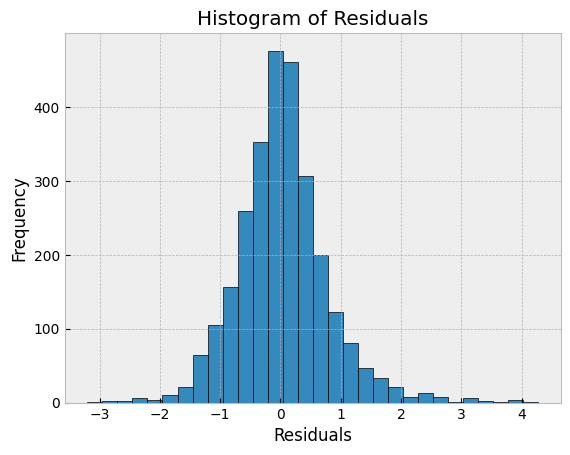

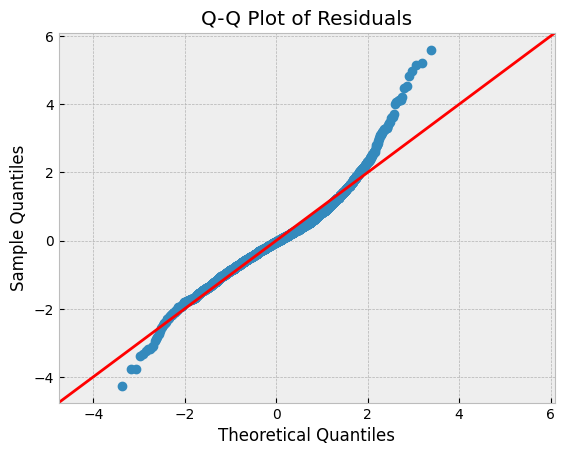

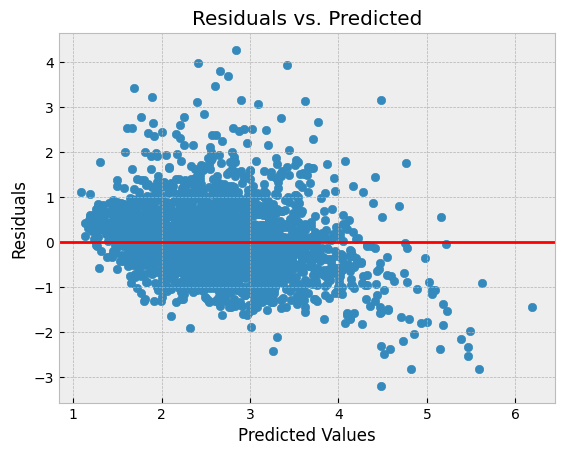

In [307]:
# Assuming 'tweedie_results' is the GLM model results object you have from fitting the model
residuals = tweedie_results.resid_response

# Plotting the residuals with a histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of the residuals to check for normality
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# You can also check for patterns in residuals with a scatter plot of predicted vs residuals
predicted_values = tweedie_results.fittedvalues
plt.scatter(predicted_values, residuals)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

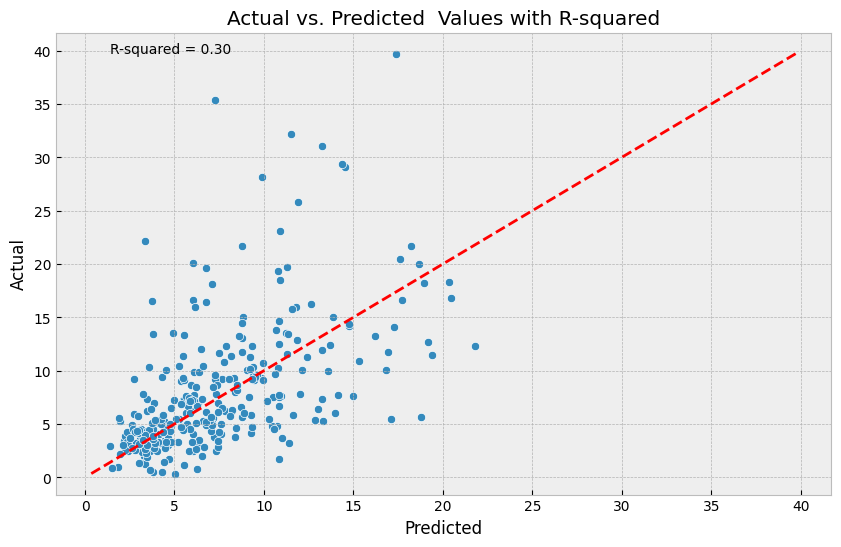

In [308]:
y_pred_tweedie = tweedie_results.predict(X_test)
plot_actual_vs_predicted(y_pred_tweedie**2,y_test**2)

# XG Boost Approach

In [309]:
# Sample Data
# X_train, X_test, y_train, y_test = ...

# Fit the scaler on the training data and transform both the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth= 1 , alpha=5, n_estimators=350)

# Fit the regressor to the training set and evaluate on the test set with verbose output
xg_reg.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

# Predict the labels of the test set
y_pred_xgb = xg_reg.predict(X_test_scaled)


[0]	validation_0-rmse:2.13901
[1]	validation_0-rmse:1.96127
[2]	validation_0-rmse:1.80308
[3]	validation_0-rmse:1.67049
[4]	validation_0-rmse:1.54766
[5]	validation_0-rmse:1.43867
[6]	validation_0-rmse:1.34464
[7]	validation_0-rmse:1.26160
[8]	validation_0-rmse:1.19202
[9]	validation_0-rmse:1.13070
[10]	validation_0-rmse:1.07680
[11]	validation_0-rmse:1.03136
[12]	validation_0-rmse:0.99331
[13]	validation_0-rmse:0.96034
[14]	validation_0-rmse:0.93516
[15]	validation_0-rmse:0.91030
[16]	validation_0-rmse:0.89035
[17]	validation_0-rmse:0.87314
[18]	validation_0-rmse:0.85721
[19]	validation_0-rmse:0.84186
[20]	validation_0-rmse:0.83015
[21]	validation_0-rmse:0.82167
[22]	validation_0-rmse:0.81320
[23]	validation_0-rmse:0.80447
[24]	validation_0-rmse:0.79716
[25]	validation_0-rmse:0.79305
[26]	validation_0-rmse:0.78717
[27]	validation_0-rmse:0.78257
[28]	validation_0-rmse:0.77993
[29]	validation_0-rmse:0.77667
[30]	validation_0-rmse:0.77298
[31]	validation_0-rmse:0.76944
[32]	validation_0-

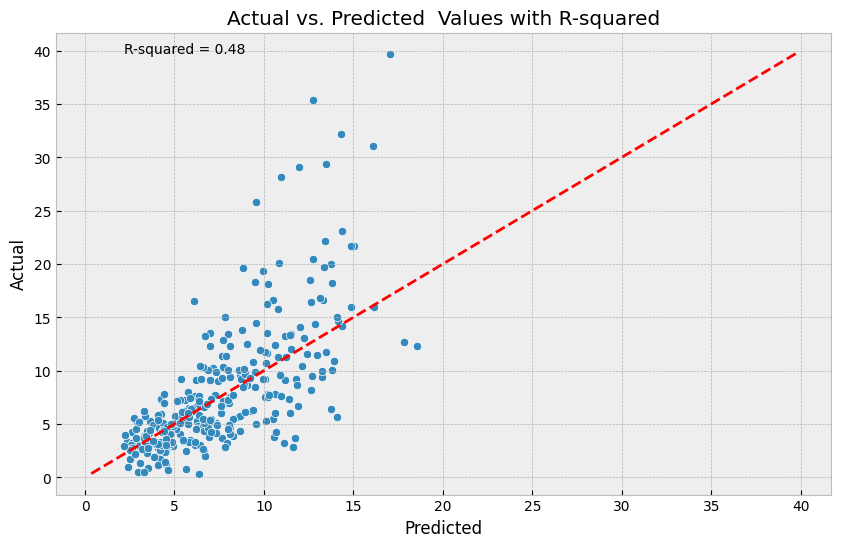

In [310]:
plot_actual_vs_predicted(y_pred_xgb**2,y_test**2 )

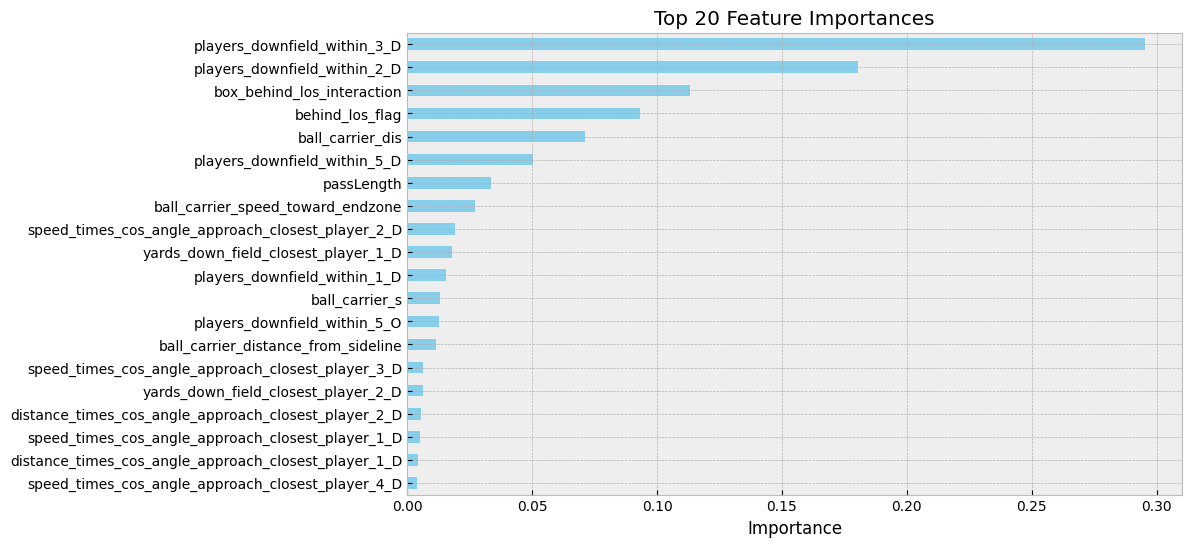

In [311]:
def plot_top_n_feature_importances(model, feature_names, n=10):
    # Get feature importances
    importances = model.feature_importances_
    
    # Convert to a Series for easy manipulation
    importance_series = pd.Series(importances, index=feature_names)
    
    # Sort the features by importance
    sorted_importance = importance_series.sort_values(ascending=False)
    
    # Select the top n features
    top_n_importance = sorted_importance.head(n)
    
    # Plot the top n feature importances
    plt.figure(figsize=(10, 6))
    top_n_importance.plot(kind='barh', color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top {n} Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

plot_top_n_feature_importances(xg_reg, predictor_cols, 20)

# Huber Approach

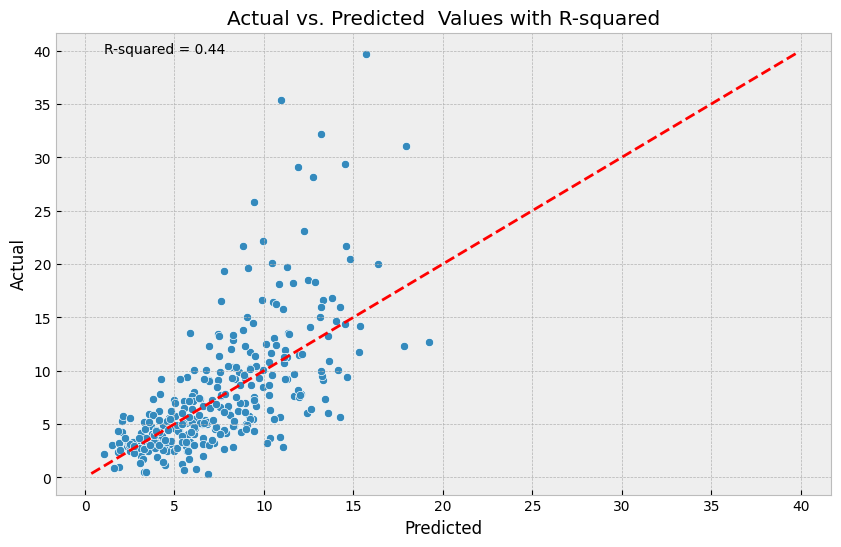

In [312]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
# Assuming X_train, y_train, X_test, y_tes

# Create a pipeline that first scales the data then applies Huber regression
huber_pipeline = make_pipeline(
    StandardScaler(),
    HuberRegressor(epsilon = 10,alpha = 10, max_iter = 2000)
)

# Fit the model
huber_pipeline.fit(X_train, y_train)

y_pred_huber = huber_pipeline.predict(X_test)
plot_actual_vs_predicted(y_pred_huber**2,y_test**2 )

# Extra Tree Approach

In [254]:
from sklearn.ensemble import ExtraTreesRegressor

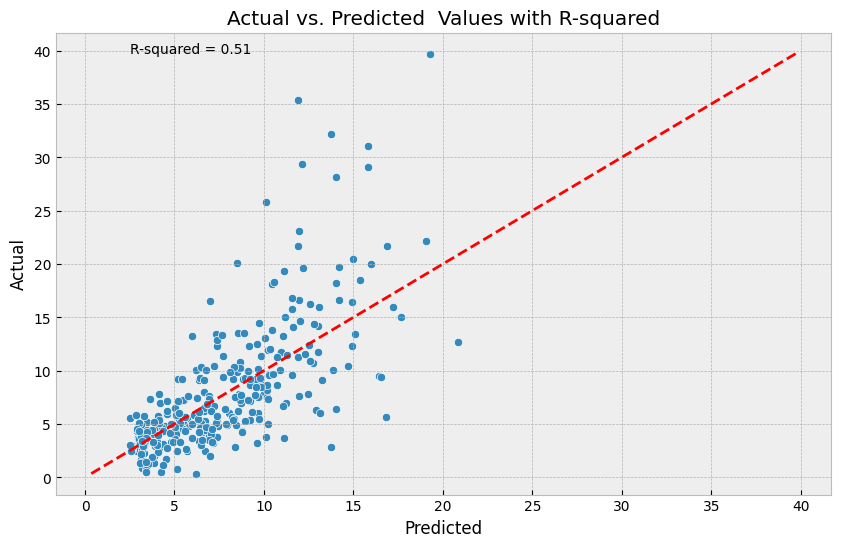

In [300]:
rf = ExtraTreesRegressor(n_estimators= 200,max_depth=15 )
rf.fit(X_train ,y_train )

# Predict the labels of the test set
y_pred_extra_trees = rf.predict(X_test)

plot_actual_vs_predicted(y_pred_extra_trees**2, y_test**2)




# Ensemble Predictions

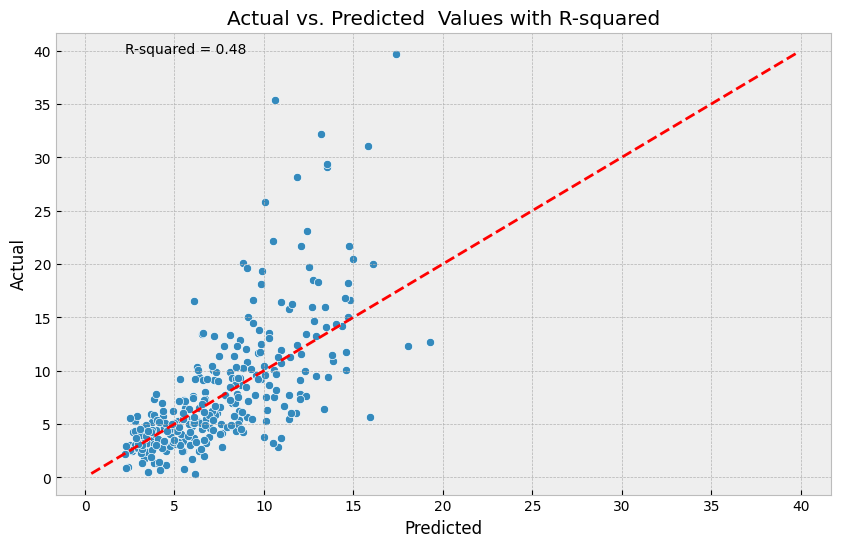

In [301]:
y_pred = (y_pred_extra_trees + y_pred_xgb + y_pred_tweedie +y_pred_huber)/4

plot_actual_vs_predicted(y_pred**2, y_test**2)

In [302]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test**2, y_pred**2)
print(np.sqrt(mse))

4.385580976328353


# Check Big Residuals

In [303]:
test_index = X_test.index
check_df = model_df.iloc[test_index,:].copy()
check_df['residuals'] = y_test-y_pred_xgb
check_df['ensemble_prediction'] = y_pred**2
check_df['glm_prediction'] = y_pred_tweedie**2
check_df['xgb_prediction'] =y_pred_xgb**2
check_df['extra_trees_prediction'] = y_pred_extra_trees**2
check_df['sqrt_yac'] = np.sqrt(check_df['yac'])

check_df['residuals'].describe()

count    308.000000
mean      -0.028766
std        0.654367
min       -1.957691
25%       -0.449866
50%       -0.031556
75%        0.283694
max        2.376580
Name: residuals, dtype: float64

In [304]:
check_df.sort_values('residuals',ascending = False)[['gameId','playId','yac','sqrt_yac','ensemble_prediction','residuals','glm_prediction' ,'xgb_prediction','extra_trees_prediction']].tail(50)

,gameId,playId,yac,sqrt_yac,ensemble_prediction,residuals,glm_prediction,xgb_prediction,extra_trees_prediction
1647,2022100900,3109,4.240003,2.059127,5.845233,-0.591293,4.294341,7.024726,6.346860
1191,2022092513,1460,1.309999,1.144552,3.168450,-0.600985,3.185627,3.046900,3.061004
483,2022091800,3523,3.460001,1.860108,6.647449,-0.626222,6.372201,6.181837,6.929489
273,2022091109,978,3.299999,1.816590,4.930925,-0.627181,4.484641,5.972018,3.818149
2747,2022103000,3042,4.940000,2.222611,8.186734,-0.652571,7.071441,8.266669,8.467008
3048,2022103012,3091,8.230001,2.868798,10.667652,-0.654510,8.440995,12.413699,10.186886
2192,2022101607,1058,7.360002,2.712932,12.030223,-0.669609,13.195883,11.441588,10.252014
247,2022091108,633,12.670000,3.559494,19.278703,-0.682131,19.120629,17.991381,20.862736
1627,2022100900,550,4.170002,2.042058,7.632877,-0.687387,9.042859,7.449872,6.483605
2993,2022103010,1365,1.750002,1.322876,5.988691,-0.702457,10.648737,4.101974,4.505359
